In [127]:
# Imports and configuration
import os
import sys
import math
import numpy as np
import pandas as pd
from typing import Dict, Any
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, 
    auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import seed_everything

# Add parent directory to path to import utils
sys.path.insert(0, os.path.abspath('..'))
from utils import setup_logger

# Setup logger
logger = setup_logger(__name__)

BASE_DATA_DIR = os.path.abspath("../data")
EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")

# Log experiment start
logger.info("="*80)
logger.info("FLAG PATTERN CLASSIFICATION EXPERIMENT")
logger.info(f"Experiment started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.info("="*80)

logger.info(f"Using preprocessed file: {PREPROC_CSV}")
assert os.path.exists(PREPROC_CSV), f"Preprocessed CSV not found: {PREPROC_CSV}"
logger.info(f"PyTorch Lightning version: {pl.__version__}")
logger.info(f"CUDA available: {torch.cuda.is_available()}")
logger.info(f"PyTorch version: {torch.__version__}")

2025-12-13 08:41:01,506 - INFO - ================================================================================
2025-12-13 08:41:01,508 - INFO - FLAG PATTERN CLASSIFICATION EXPERIMENT
2025-12-13 08:41:01,508 - INFO - Experiment started at: 2025-12-13 08:41:01
2025-12-13 08:41:01,509 - INFO - ================================================================================
2025-12-13 08:41:01,510 - INFO - Using preprocessed file: /work/data/export/segments_preproc_24.csv
2025-12-13 08:41:01,513 - INFO - PyTorch Lightning version: 2.6.0
2025-12-13 08:41:01,513 - INFO - CUDA available: True
2025-12-13 08:41:01,514 - INFO - PyTorch version: 2.6.0+cu124


In [128]:
# Set random seeds for reproducibility
SEED = 1
seed_everything(SEED, workers=True)

logger.info("\n" + "="*80)
logger.info("CONFIGURATION - Random Seed")
logger.info("="*80)
logger.info(f"Random seed set to: {SEED}")
logger.info("This ensures reproducible results across runs")

Seed set to 1


2025-12-13 08:41:01,573 - INFO - 
2025-12-13 08:41:01,574 - INFO - CONFIGURATION - Random Seed
2025-12-13 08:41:01,575 - INFO - ================================================================================
2025-12-13 08:41:01,576 - INFO - Random seed set to: 1
2025-12-13 08:41:01,576 - INFO - This ensures reproducible results across runs


In [129]:
# Model evaluation configuration
# Change this single variable to switch the primary metric for model selection
# Options: 'auc_ovo', 'auc_ovr', 'f1', 'accuracy', 'pr_auc'
PRIMARY_METRIC = 'pr_auc'

# Metric display names and whether higher is better
METRIC_CONFIG = {
    'auc_ovo': {
        'name': 'AUC-ROC (OvO)',
        'short': 'ovo',
        'higher_is_better': True,
        'monitor': 'val_auc_ovo',
        'description': 'One-vs-One: evaluates all pairwise class comparisons'
    },
    'auc_ovr': {
        'name': 'AUC-ROC (OvR)',
        'short': 'ovr',
        'higher_is_better': True,
        'monitor': 'val_auc_ovr',
        'description': 'One-vs-Rest: evaluates each class vs all others'
    },
    'f1': {
        'name': 'F1 Score (macro)',
        'short': 'f1',
        'higher_is_better': True,
        'monitor': 'val_f1',
        'description': 'Harmonic mean of precision and recall'
    },
    'accuracy': {
        'name': 'Accuracy',
        'short': 'acc',
        'higher_is_better': True,
        'monitor': 'val_accuracy',
        'description': 'Proportion of correct predictions'
    },
    'pr_auc': {
        'name': 'PR-AUC (macro)',
        'short': 'pr',
        'higher_is_better': True,
        'monitor': 'val_pr_auc',
        'description': 'Precision-Recall curve area (macro): better for imbalanced classes'
    }
}

logger.info("\n" + "="*80)
logger.info("CONFIGURATION - Primary Evaluation Metric")
logger.info("="*80)
logger.info(f"Primary metric: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
logger.info(f"Monitor: {METRIC_CONFIG[PRIMARY_METRIC]['monitor']}")
logger.info(f"Description: {METRIC_CONFIG[PRIMARY_METRIC]['description']}")
logger.info(f"Higher is better: {METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better']}")

2025-12-13 08:41:01,628 - INFO - 
2025-12-13 08:41:01,630 - INFO - CONFIGURATION - Primary Evaluation Metric
2025-12-13 08:41:01,630 - INFO - ================================================================================
2025-12-13 08:41:01,631 - INFO - Primary metric: PR-AUC (macro)
2025-12-13 08:41:01,632 - INFO - Monitor: val_pr_auc
2025-12-13 08:41:01,633 - INFO - Description: Precision-Recall curve area (macro): better for imbalanced classes
2025-12-13 08:41:01,635 - INFO - Higher is better: True


In [130]:
# Load preprocessed dataset and build segment-level sequences
logger.info("\n" + "="*80)
logger.info("DATA PROCESSING - Loading and Preparing Data")
logger.info("="*80)

df = pd.read_csv(PREPROC_CSV)
logger.info(f"Loaded preprocessed data: {df.shape[0]} rows, {df.shape[1]} columns")

# Ensure correct ordering within each segment
df = df.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

feature_cols = [c for c in df.columns if c not in ["segment_id", "label", "csv_file", "seq_pos"]]
logger.info(f"Feature columns ({len(feature_cols)}): {feature_cols}")

# Group into (segment, sequence of length 24, label)
segments = []
labels = []

for seg_id, g in df.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    # Expect 24 steps; if shorter/longer, adjust with simple strategies
    if feat.shape[0] < 24:
        # pad by repeating last step
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        # truncate extra steps
        feat = feat[:24, :]

    assert feat.shape[0] == 24, feat.shape
    segments.append(feat)
    labels.append(g["label"].iloc[0])

X = np.stack(segments, axis=0)  # (N, 24, F)
y = np.array(labels)

logger.info(f"Data shape: {X.shape[0]} segments × {X.shape[1]} timesteps × {X.shape[2]} features")
logger.info(f"Label distribution:")
label_dist = pd.Series(y).value_counts()
for label, count in label_dist.items():
    logger.info(f"  {label}: {count} samples ({count/len(y)*100:.1f}%)")
logger.info("Data loading and preprocessing completed successfully")

2025-12-13 08:41:01,690 - INFO - 
2025-12-13 08:41:01,691 - INFO - DATA PROCESSING - Loading and Preparing Data
2025-12-13 08:41:01,691 - INFO - ================================================================================
2025-12-13 08:41:01,706 - INFO - Loaded preprocessed data: 4392 rows, 12 columns
2025-12-13 08:41:01,707 - INFO - Feature columns (8): ['open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']
2025-12-13 08:41:01,751 - INFO - Data shape: 183 segments × 24 timesteps × 8 features
2025-12-13 08:41:01,752 - INFO - Label distribution:
2025-12-13 08:41:01,753 - INFO -   Bullish Normal: 48 samples (26.2%)
2025-12-13 08:41:01,754 - INFO -   Bearish Normal: 38 samples (20.8%)
2025-12-13 08:41:01,754 - INFO -   Bearish Pennant: 29 samples (15.8%)
2025-12-13 08:41:01,755 - INFO -   Bullish Wedge: 23 samples (12.6%)
2025-12-13 08:41:01,755 - INFO -   Bullish Pennant: 23 samples (12.6%)
2025-12-13 08:41:01,756 - INFO -   Be

In [131]:
# Encode labels as integers
label_values = np.sort(pd.unique(y))
label_to_idx = {lbl: i for i, lbl in enumerate(label_values)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

y_idx = np.vectorize(label_to_idx.get)(y)
num_classes = len(label_values)

logger.info(f"\nLabel encoding: {num_classes} classes")
for lbl, idx in label_to_idx.items():
    logger.info(f"  '{lbl}' → {idx}")

2025-12-13 08:41:01,812 - INFO - 
Label encoding: 6 classes
2025-12-13 08:41:01,813 - INFO -   'Bearish Normal' → 0
2025-12-13 08:41:01,814 - INFO -   'Bearish Pennant' → 1
2025-12-13 08:41:01,815 - INFO -   'Bearish Wedge' → 2
2025-12-13 08:41:01,816 - INFO -   'Bullish Normal' → 3
2025-12-13 08:41:01,816 - INFO -   'Bullish Pennant' → 4
2025-12-13 08:41:01,817 - INFO -   'Bullish Wedge' → 5


In [132]:
# Train/validation split at segment level
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx, test_size=0.2, random_state=SEED, stratify=y_idx,
 )

logger.info("\n" + "="*80)
logger.info("DATA SPLIT - Train/Validation")
logger.info("="*80)
logger.info(f"Training segments: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
logger.info(f"Validation segments: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
logger.info(f"Split ratio: 80/20 (stratified by label)")

class SegmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SegmentDataset(X_train, y_train)
val_ds = SegmentDataset(X_val, y_val)

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y_idx)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)

logger.info(f"\nClass distribution (all data):")
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    logger.info(f"  Class {i} ({idx_to_label[i]}): {count} samples, weight: {weight:.4f}")

2025-12-13 08:41:01,879 - INFO - 
2025-12-13 08:41:01,880 - INFO - DATA SPLIT - Train/Validation
2025-12-13 08:41:01,880 - INFO - ================================================================================
2025-12-13 08:41:01,881 - INFO - Training segments: 146 (79.8%)
2025-12-13 08:41:01,882 - INFO - Validation segments: 37 (20.2%)
2025-12-13 08:41:01,882 - INFO - Split ratio: 80/20 (stratified by label)
2025-12-13 08:41:01,883 - INFO - 
Class distribution (all data):
2025-12-13 08:41:01,884 - INFO -   Class 0 (Bearish Normal): 38 samples, weight: 0.7377
2025-12-13 08:41:01,885 - INFO -   Class 1 (Bearish Pennant): 29 samples, weight: 0.9666
2025-12-13 08:41:01,886 - INFO -   Class 2 (Bearish Wedge): 22 samples, weight: 1.2742
2025-12-13 08:41:01,886 - INFO -   Class 3 (Bullish Normal): 48 samples, weight: 0.5840
2025-12-13 08:41:01,887 - INFO -   Class 4 (Bullish Pennant): 23 samples, weight: 1.2188
2025-12-13 08:41:01,888 - INFO -   Class 5 (Bullish Wedge): 23 samples, weight: 

In [133]:
# PyTorch Lightning Module
class FlagPatternClassifier(pl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        class_weights: np.ndarray,
        hidden_channels: int = 64,
        lr: float = 1e-3,
        weight_decay: float = 1e-4,
        batch_size: int = 12
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Model architecture with 3 conv layers and max pooling
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_dim, hidden_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hidden_channels // 2, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )
        
        # Loss function with class weights
        self.class_weights = torch.FloatTensor(class_weights)
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        
        # Store predictions for epoch-end metrics
        self.validation_step_outputs = []
        self.training_step_outputs = []
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, F) -> (B, F, T)
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.pool(h).squeeze(-1)
        logits = self.fc(h)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        self.training_step_outputs.append({
            'loss': loss,
            'preds': preds.detach().cpu(),
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        })
        
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        self.validation_step_outputs.append({
            'loss': loss,
            'preds': preds.detach().cpu(),
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        })
        
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self):
        self._compute_epoch_metrics(self.training_step_outputs, 'train')
        self.training_step_outputs.clear()
    
    def on_validation_epoch_end(self):
        self._compute_epoch_metrics(self.validation_step_outputs, 'val')
        self.validation_step_outputs.clear()
    
    def _compute_epoch_metrics(self, outputs, prefix):
        all_preds = torch.cat([x['preds'] for x in outputs]).numpy()
        all_probs = torch.cat([x['probs'] for x in outputs]).numpy()
        all_targets = torch.cat([x['targets'] for x in outputs]).numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        try:
            auc_ovo = roc_auc_score(all_targets, all_probs, multi_class='ovo', average='macro')
            auc_ovr = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
        except ValueError:
            auc_ovo = 0.0
            auc_ovr = 0.0
        
        try:
            y_bin = label_binarize(all_targets, classes=range(all_probs.shape[1]))
            pr_auc_per_class = []
            for i in range(all_probs.shape[1]):
                pr_auc_per_class.append(average_precision_score(y_bin[:, i], all_probs[:, i]))
            pr_auc = np.mean(pr_auc_per_class)
        except ValueError:
            pr_auc = 0.0
        
        # Log all metrics
        self.log(f'{prefix}_accuracy', accuracy, prog_bar=True)
        self.log(f'{prefix}_f1', f1, prog_bar=True)
        self.log(f'{prefix}_auc_ovo', auc_ovo, prog_bar=True)
        self.log(f'{prefix}_auc_ovr', auc_ovr, prog_bar=True)
        self.log(f'{prefix}_pr_auc', pr_auc, prog_bar=True)
        
        # Log to our custom logger
        epoch = self.current_epoch
        logger.info(f"Epoch {epoch} - {prefix.upper()} | Loss: {np.mean([x['loss'].item() for x in outputs]):.4f} | "
                   f"Acc: {accuracy:.4f} | F1: {f1:.4f} | PR-AUC: {pr_auc:.4f} | "
                   f"AUC-OvO: {auc_ovo:.4f} | AUC-OvR: {auc_ovr:.4f}")
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=20
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }

batch_size = 12

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = FlagPatternClassifier(
    input_dim=X.shape[2],
    num_classes=num_classes,
    class_weights=class_weights,
    hidden_channels=64,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=batch_size
)

logger.info("\n" + "="*80)
logger.info("MODEL ARCHITECTURE")
logger.info("="*80)
logger.info(str(model))
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f"\nTotal parameters: {total_params:,}")
logger.info(f"Trainable parameters: {trainable_params:,}")
logger.info(f"Non-trainable parameters: {total_params - trainable_params:,}")

2025-12-13 08:41:01,951 - INFO - 
2025-12-13 08:41:01,952 - INFO - MODEL ARCHITECTURE
2025-12-13 08:41:01,953 - INFO - ================================================================================
2025-12-13 08:41:01,954 - INFO - FlagPatternClassifier(
  (conv1): Sequential(
    (0): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    

2025-12-13 08:41:01,955 - INFO - 
Total parameters: 42,694
2025-12-13 08:41:01,956 - INFO - Trainable parameters: 42,694
2025-12-13 08:41:01,956 - INFO - Non-trainable parameters: 0


In [134]:
# Setup callbacks and trainer
checkpoint_dir = os.path.join(EXPORT_DIR, "checkpoints_v2")
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'best_model_{METRIC_CONFIG[PRIMARY_METRIC]["short"]}' + '_{epoch:02d}_{' + METRIC_CONFIG[PRIMARY_METRIC]["monitor"] + ':.4f}',
    monitor=METRIC_CONFIG[PRIMARY_METRIC]["monitor"],
    mode='max' if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better'] else 'min',
    save_top_k=1,
    verbose=True
)

# Training hyperparameters
MAX_EPOCHS = 50
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback],
    deterministic=True,
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True
)

logger.info("\n" + "="*80)
logger.info("CONFIGURATION - Training Hyperparameters")
logger.info("="*80)
logger.info(f"Maximum epochs: {MAX_EPOCHS}")
logger.info(f"Batch size: {BATCH_SIZE}")
logger.info(f"Learning rate: {LEARNING_RATE}")
logger.info(f"Weight decay: {WEIGHT_DECAY}")
logger.info(f"Optimizer: AdamW")
logger.info(f"LR Scheduler: CosineAnnealingLR (T_max=20)")
logger.info(f"Loss function: CrossEntropyLoss (with class weights)")
logger.info(f"Accelerator: {'GPU' if torch.cuda.is_available() else 'CPU'}")
logger.info(f"Checkpoint directory: {checkpoint_dir}")
logger.info(f"Model selection metric: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
logger.info(f"Monitor: {METRIC_CONFIG[PRIMARY_METRIC]['monitor']} (mode: {'max' if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better'] else 'min'})")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


2025-12-13 08:41:02,028 - INFO - 
2025-12-13 08:41:02,029 - INFO - CONFIGURATION - Training Hyperparameters
2025-12-13 08:41:02,030 - INFO - ================================================================================
2025-12-13 08:41:02,031 - INFO - Maximum epochs: 50
2025-12-13 08:41:02,031 - INFO - Batch size: 12
2025-12-13 08:41:02,032 - INFO - Learning rate: 0.001
2025-12-13 08:41:02,033 - INFO - Weight decay: 0.0001
2025-12-13 08:41:02,034 - INFO - Optimizer: AdamW
2025-12-13 08:41:02,034 - INFO - LR Scheduler: CosineAnnealingLR (T_max=20)
2025-12-13 08:41:02,035 - INFO - Loss function: CrossEntropyLoss (with class weights)
2025-12-13 08:41:02,036 - INFO - Accelerator: GPU
2025-12-13 08:41:02,037 - INFO - Checkpoint directory: /work/data/export/checkpoints_v2
2025-12-13 08:41:02,037 - INFO - Model selection metric: PR-AUC (macro)
2025-12-13 08:41:02,038 - INFO - Monitor: val_pr_auc (mode: max)


In [135]:
# Train the model
logger.info("\n" + "="*80)
logger.info("TRAINING PROGRESS")
logger.info("="*80)
logger.info(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

trainer.fit(model, train_loader, val_loader)

logger.info(f"\nTraining completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.info(f"Best checkpoint saved: {checkpoint_callback.best_model_path}")
logger.info(f"Best {METRIC_CONFIG[PRIMARY_METRIC]['name']}: {checkpoint_callback.best_model_score:.4f}")

2025-12-13 08:41:02,092 - INFO - 
2025-12-13 08:41:02,093 - INFO - TRAINING PROGRESS
2025-12-13 08:41:02,094 - INFO - ================================================================================
2025-12-13 08:41:02,095 - INFO - Training started at: 2025-12-13 08:41:02


/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /work/data/export/checkpoints_v2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | conv1     | Sequential        | 864    | train | 0    
1 | conv2     | Sequential        | 6.3 K  | train | 0    
2 | conv3     | Sequential        | 25.0 K | train | 0    
3 | pool      | AdaptiveAvgPool1d | 0      | train | 0    
4 | fc        | Sequential        | 10.5 K | train | 0    
5 | criterion | CrossEntropyLoss  | 0      | train | 0    
----------------------------------------------------------------
42.7 K    Trainable params
0         Non-trainable params
42.7 K    Total params
0.171     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


2025-12-13 08:41:02,281 - INFO - Epoch 0 - VAL | Loss: 1.8256 | Acc: 0.1667 | F1: 0.0476 | PR-AUC: 0.3424 | AUC-OvO: 0.6351 | AUC-OvR: 0.6279


/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:02,606 - INFO - Epoch 0 - VAL | Loss: 1.7235 | Acc: 0.2432 | F1: 0.1323 | PR-AUC: 0.3170 | AUC-OvO: 0.6664 | AUC-OvR: 0.6699
2025-12-13 08:41:02,654 - INFO - Epoch 0 - TRAIN | Loss: 1.8939 | Acc: 0.1986 | F1: 0.1320 | PR-AUC: 0.1694 | AUC-OvO: 0.4650 | AUC-OvR: 0.4660


Epoch 0, global step 13: 'val_pr_auc' reached 0.31699 (best 0.31699), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=00_val_pr_auc=0.3170.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:02,905 - INFO - Epoch 1 - VAL | Loss: 1.5729 | Acc: 0.4054 | F1: 0.2340 | PR-AUC: 0.3428 | AUC-OvO: 0.7034 | AUC-OvR: 0.7134
2025-12-13 08:41:02,937 - INFO - Epoch 1 - TRAIN | Loss: 1.6519 | Acc: 0.3082 | F1: 0.2317 | PR-AUC: 0.3182 | AUC-OvO: 0.6960 | AUC-OvR: 0.7010


Epoch 1, global step 26: 'val_pr_auc' reached 0.34280 (best 0.34280), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=01_val_pr_auc=0.3428.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:03,150 - INFO - Epoch 2 - VAL | Loss: 1.4311 | Acc: 0.4054 | F1: 0.2565 | PR-AUC: 0.3181 | AUC-OvO: 0.6819 | AUC-OvR: 0.6889
2025-12-13 08:41:03,186 - INFO - Epoch 2 - TRAIN | Loss: 1.5831 | Acc: 0.4110 | F1: 0.3517 | PR-AUC: 0.3515 | AUC-OvO: 0.7480 | AUC-OvR: 0.7505


Epoch 2, global step 39: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:03,390 - INFO - Epoch 3 - VAL | Loss: 1.4523 | Acc: 0.2432 | F1: 0.1692 | PR-AUC: 0.3624 | AUC-OvO: 0.7013 | AUC-OvR: 0.7080
2025-12-13 08:41:03,421 - INFO - Epoch 3 - TRAIN | Loss: 1.5449 | Acc: 0.3630 | F1: 0.3077 | PR-AUC: 0.3367 | AUC-OvO: 0.7284 | AUC-OvR: 0.7308


Epoch 3, global step 52: 'val_pr_auc' reached 0.36241 (best 0.36241), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=03_val_pr_auc=0.3624.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:03,633 - INFO - Epoch 4 - VAL | Loss: 1.4203 | Acc: 0.2432 | F1: 0.1678 | PR-AUC: 0.3376 | AUC-OvO: 0.7011 | AUC-OvR: 0.7105
2025-12-13 08:41:03,668 - INFO - Epoch 4 - TRAIN | Loss: 1.3727 | Acc: 0.4726 | F1: 0.4120 | PR-AUC: 0.4537 | AUC-OvO: 0.8151 | AUC-OvR: 0.8167


Epoch 4, global step 65: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:03,871 - INFO - Epoch 5 - VAL | Loss: 1.3969 | Acc: 0.1892 | F1: 0.1415 | PR-AUC: 0.3370 | AUC-OvO: 0.7072 | AUC-OvR: 0.7173
2025-12-13 08:41:03,903 - INFO - Epoch 5 - TRAIN | Loss: 1.3148 | Acc: 0.4452 | F1: 0.3904 | PR-AUC: 0.4040 | AUC-OvO: 0.8106 | AUC-OvR: 0.8095


Epoch 5, global step 78: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:04,105 - INFO - Epoch 6 - VAL | Loss: 1.3438 | Acc: 0.2973 | F1: 0.2166 | PR-AUC: 0.3615 | AUC-OvO: 0.7220 | AUC-OvR: 0.7288
2025-12-13 08:41:04,145 - INFO - Epoch 6 - TRAIN | Loss: 1.3455 | Acc: 0.4384 | F1: 0.4157 | PR-AUC: 0.4230 | AUC-OvO: 0.8156 | AUC-OvR: 0.8148


Epoch 6, global step 91: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:04,379 - INFO - Epoch 7 - VAL | Loss: 1.3428 | Acc: 0.2703 | F1: 0.2068 | PR-AUC: 0.3355 | AUC-OvO: 0.7241 | AUC-OvR: 0.7296
2025-12-13 08:41:04,410 - INFO - Epoch 7 - TRAIN | Loss: 1.2931 | Acc: 0.4521 | F1: 0.4096 | PR-AUC: 0.4669 | AUC-OvO: 0.8283 | AUC-OvR: 0.8276


Epoch 7, global step 104: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:04,670 - INFO - Epoch 8 - VAL | Loss: 1.3777 | Acc: 0.2162 | F1: 0.1756 | PR-AUC: 0.3637 | AUC-OvO: 0.7490 | AUC-OvR: 0.7525
2025-12-13 08:41:04,714 - INFO - Epoch 8 - TRAIN | Loss: 1.2857 | Acc: 0.3699 | F1: 0.3634 | PR-AUC: 0.4063 | AUC-OvO: 0.8142 | AUC-OvR: 0.8143


Epoch 8, global step 117: 'val_pr_auc' reached 0.36370 (best 0.36370), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=08_val_pr_auc=0.3637.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:04,930 - INFO - Epoch 9 - VAL | Loss: 1.3715 | Acc: 0.2432 | F1: 0.2159 | PR-AUC: 0.3514 | AUC-OvO: 0.7435 | AUC-OvR: 0.7463
2025-12-13 08:41:04,976 - INFO - Epoch 9 - TRAIN | Loss: 1.1935 | Acc: 0.5137 | F1: 0.5213 | PR-AUC: 0.5485 | AUC-OvO: 0.8657 | AUC-OvR: 0.8641


Epoch 9, global step 130: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:05,148 - INFO - Epoch 10 - VAL | Loss: 1.3295 | Acc: 0.2703 | F1: 0.2612 | PR-AUC: 0.3611 | AUC-OvO: 0.7447 | AUC-OvR: 0.7473
2025-12-13 08:41:05,181 - INFO - Epoch 10 - TRAIN | Loss: 1.3055 | Acc: 0.4315 | F1: 0.4336 | PR-AUC: 0.4896 | AUC-OvO: 0.8318 | AUC-OvR: 0.8316


Epoch 10, global step 143: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:05,381 - INFO - Epoch 11 - VAL | Loss: 1.3197 | Acc: 0.2432 | F1: 0.2093 | PR-AUC: 0.3712 | AUC-OvO: 0.7552 | AUC-OvR: 0.7562
2025-12-13 08:41:05,434 - INFO - Epoch 11 - TRAIN | Loss: 1.1713 | Acc: 0.5274 | F1: 0.5193 | PR-AUC: 0.5467 | AUC-OvO: 0.8710 | AUC-OvR: 0.8704


Epoch 11, global step 156: 'val_pr_auc' reached 0.37123 (best 0.37123), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=11_val_pr_auc=0.3712.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:05,680 - INFO - Epoch 12 - VAL | Loss: 1.3551 | Acc: 0.2432 | F1: 0.1899 | PR-AUC: 0.3627 | AUC-OvO: 0.7453 | AUC-OvR: 0.7478
2025-12-13 08:41:05,706 - INFO - Epoch 12 - TRAIN | Loss: 1.2116 | Acc: 0.4521 | F1: 0.4376 | PR-AUC: 0.4720 | AUC-OvO: 0.8430 | AUC-OvR: 0.8438


Epoch 12, global step 169: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:05,921 - INFO - Epoch 13 - VAL | Loss: 1.3462 | Acc: 0.2162 | F1: 0.1667 | PR-AUC: 0.3621 | AUC-OvO: 0.7464 | AUC-OvR: 0.7467
2025-12-13 08:41:05,962 - INFO - Epoch 13 - TRAIN | Loss: 1.1208 | Acc: 0.5274 | F1: 0.5209 | PR-AUC: 0.5619 | AUC-OvO: 0.8739 | AUC-OvR: 0.8731


Epoch 13, global step 182: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:06,169 - INFO - Epoch 14 - VAL | Loss: 1.3595 | Acc: 0.2162 | F1: 0.1882 | PR-AUC: 0.3564 | AUC-OvO: 0.7387 | AUC-OvR: 0.7422
2025-12-13 08:41:06,214 - INFO - Epoch 14 - TRAIN | Loss: 1.2582 | Acc: 0.4521 | F1: 0.4411 | PR-AUC: 0.5014 | AUC-OvO: 0.8529 | AUC-OvR: 0.8509


Epoch 14, global step 195: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:06,389 - INFO - Epoch 15 - VAL | Loss: 1.3506 | Acc: 0.2162 | F1: 0.2170 | PR-AUC: 0.3927 | AUC-OvO: 0.7633 | AUC-OvR: 0.7636
2025-12-13 08:41:06,435 - INFO - Epoch 15 - TRAIN | Loss: 1.1579 | Acc: 0.5479 | F1: 0.5317 | PR-AUC: 0.5647 | AUC-OvO: 0.8719 | AUC-OvR: 0.8706


Epoch 15, global step 208: 'val_pr_auc' reached 0.39273 (best 0.39273), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=15_val_pr_auc=0.3927.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:06,695 - INFO - Epoch 16 - VAL | Loss: 1.3617 | Acc: 0.2432 | F1: 0.2055 | PR-AUC: 0.3685 | AUC-OvO: 0.7580 | AUC-OvR: 0.7584
2025-12-13 08:41:06,762 - INFO - Epoch 16 - TRAIN | Loss: 1.1814 | Acc: 0.4178 | F1: 0.4119 | PR-AUC: 0.4668 | AUC-OvO: 0.8397 | AUC-OvR: 0.8382


Epoch 16, global step 221: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:06,981 - INFO - Epoch 17 - VAL | Loss: 1.3688 | Acc: 0.2432 | F1: 0.2033 | PR-AUC: 0.3574 | AUC-OvO: 0.7451 | AUC-OvR: 0.7469
2025-12-13 08:41:07,015 - INFO - Epoch 17 - TRAIN | Loss: 1.0437 | Acc: 0.5479 | F1: 0.5421 | PR-AUC: 0.5995 | AUC-OvO: 0.8913 | AUC-OvR: 0.8911


Epoch 17, global step 234: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:07,229 - INFO - Epoch 18 - VAL | Loss: 1.3745 | Acc: 0.2432 | F1: 0.2027 | PR-AUC: 0.3388 | AUC-OvO: 0.7373 | AUC-OvR: 0.7410
2025-12-13 08:41:07,274 - INFO - Epoch 18 - TRAIN | Loss: 1.0921 | Acc: 0.4932 | F1: 0.4987 | PR-AUC: 0.5707 | AUC-OvO: 0.8811 | AUC-OvR: 0.8797


Epoch 18, global step 247: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:07,464 - INFO - Epoch 19 - VAL | Loss: 1.3689 | Acc: 0.2162 | F1: 0.1897 | PR-AUC: 0.3350 | AUC-OvO: 0.7325 | AUC-OvR: 0.7356
2025-12-13 08:41:07,505 - INFO - Epoch 19 - TRAIN | Loss: 1.2694 | Acc: 0.4315 | F1: 0.4190 | PR-AUC: 0.4850 | AUC-OvO: 0.8379 | AUC-OvR: 0.8376


Epoch 19, global step 260: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:07,696 - INFO - Epoch 20 - VAL | Loss: 1.3723 | Acc: 0.2432 | F1: 0.2027 | PR-AUC: 0.3534 | AUC-OvO: 0.7443 | AUC-OvR: 0.7470
2025-12-13 08:41:07,731 - INFO - Epoch 20 - TRAIN | Loss: 1.1685 | Acc: 0.4384 | F1: 0.4370 | PR-AUC: 0.4377 | AUC-OvO: 0.8467 | AUC-OvR: 0.8462


Epoch 20, global step 273: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:07,951 - INFO - Epoch 21 - VAL | Loss: 1.3708 | Acc: 0.2432 | F1: 0.2027 | PR-AUC: 0.3506 | AUC-OvO: 0.7468 | AUC-OvR: 0.7491
2025-12-13 08:41:07,986 - INFO - Epoch 21 - TRAIN | Loss: 1.1126 | Acc: 0.5137 | F1: 0.5143 | PR-AUC: 0.5381 | AUC-OvO: 0.8672 | AUC-OvR: 0.8651


Epoch 21, global step 286: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:08,219 - INFO - Epoch 22 - VAL | Loss: 1.3688 | Acc: 0.2432 | F1: 0.2027 | PR-AUC: 0.3689 | AUC-OvO: 0.7542 | AUC-OvR: 0.7562
2025-12-13 08:41:08,269 - INFO - Epoch 22 - TRAIN | Loss: 1.1424 | Acc: 0.4178 | F1: 0.4083 | PR-AUC: 0.5060 | AUC-OvO: 0.8594 | AUC-OvR: 0.8561


Epoch 22, global step 299: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:08,463 - INFO - Epoch 23 - VAL | Loss: 1.3615 | Acc: 0.2432 | F1: 0.2108 | PR-AUC: 0.3584 | AUC-OvO: 0.7482 | AUC-OvR: 0.7500
2025-12-13 08:41:08,516 - INFO - Epoch 23 - TRAIN | Loss: 1.0655 | Acc: 0.5068 | F1: 0.4990 | PR-AUC: 0.5740 | AUC-OvO: 0.8766 | AUC-OvR: 0.8736


Epoch 23, global step 312: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:08,695 - INFO - Epoch 24 - VAL | Loss: 1.3620 | Acc: 0.2432 | F1: 0.2132 | PR-AUC: 0.3565 | AUC-OvO: 0.7559 | AUC-OvR: 0.7573
2025-12-13 08:41:08,740 - INFO - Epoch 24 - TRAIN | Loss: 1.1245 | Acc: 0.5342 | F1: 0.5217 | PR-AUC: 0.5524 | AUC-OvO: 0.8702 | AUC-OvR: 0.8685


Epoch 24, global step 325: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:09,006 - INFO - Epoch 25 - VAL | Loss: 1.3625 | Acc: 0.2703 | F1: 0.2383 | PR-AUC: 0.3528 | AUC-OvO: 0.7480 | AUC-OvR: 0.7511
2025-12-13 08:41:09,054 - INFO - Epoch 25 - TRAIN | Loss: 1.0981 | Acc: 0.4658 | F1: 0.4572 | PR-AUC: 0.5287 | AUC-OvO: 0.8681 | AUC-OvR: 0.8665


Epoch 25, global step 338: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:09,281 - INFO - Epoch 26 - VAL | Loss: 1.3732 | Acc: 0.2432 | F1: 0.2205 | PR-AUC: 0.3794 | AUC-OvO: 0.7493 | AUC-OvR: 0.7522
2025-12-13 08:41:09,315 - INFO - Epoch 26 - TRAIN | Loss: 1.0841 | Acc: 0.5685 | F1: 0.5578 | PR-AUC: 0.5945 | AUC-OvO: 0.8879 | AUC-OvR: 0.8874


Epoch 26, global step 351: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:09,569 - INFO - Epoch 27 - VAL | Loss: 1.3603 | Acc: 0.2162 | F1: 0.1922 | PR-AUC: 0.3910 | AUC-OvO: 0.7684 | AUC-OvR: 0.7666
2025-12-13 08:41:09,617 - INFO - Epoch 27 - TRAIN | Loss: 1.1491 | Acc: 0.5548 | F1: 0.5553 | PR-AUC: 0.5772 | AUC-OvO: 0.8869 | AUC-OvR: 0.8852


Epoch 27, global step 364: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:09,840 - INFO - Epoch 28 - VAL | Loss: 1.3678 | Acc: 0.2162 | F1: 0.1704 | PR-AUC: 0.3815 | AUC-OvO: 0.7649 | AUC-OvR: 0.7620
2025-12-13 08:41:09,867 - INFO - Epoch 28 - TRAIN | Loss: 1.0890 | Acc: 0.4589 | F1: 0.4567 | PR-AUC: 0.5686 | AUC-OvO: 0.8748 | AUC-OvR: 0.8741


Epoch 28, global step 377: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:10,120 - INFO - Epoch 29 - VAL | Loss: 1.3733 | Acc: 0.2432 | F1: 0.1913 | PR-AUC: 0.3783 | AUC-OvO: 0.7554 | AUC-OvR: 0.7554
2025-12-13 08:41:10,155 - INFO - Epoch 29 - TRAIN | Loss: 1.0638 | Acc: 0.5822 | F1: 0.5741 | PR-AUC: 0.6132 | AUC-OvO: 0.8910 | AUC-OvR: 0.8888


Epoch 29, global step 390: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:10,382 - INFO - Epoch 30 - VAL | Loss: 1.3594 | Acc: 0.3243 | F1: 0.3152 | PR-AUC: 0.3927 | AUC-OvO: 0.7553 | AUC-OvR: 0.7573
2025-12-13 08:41:10,411 - INFO - Epoch 30 - TRAIN | Loss: 1.0248 | Acc: 0.5479 | F1: 0.5308 | PR-AUC: 0.5921 | AUC-OvO: 0.8942 | AUC-OvR: 0.8924


Epoch 30, global step 403: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:10,629 - INFO - Epoch 31 - VAL | Loss: 1.4085 | Acc: 0.2973 | F1: 0.2614 | PR-AUC: 0.3879 | AUC-OvO: 0.7630 | AUC-OvR: 0.7656
2025-12-13 08:41:10,655 - INFO - Epoch 31 - TRAIN | Loss: 1.1097 | Acc: 0.5274 | F1: 0.5136 | PR-AUC: 0.5714 | AUC-OvO: 0.8823 | AUC-OvR: 0.8809


Epoch 31, global step 416: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:10,904 - INFO - Epoch 32 - VAL | Loss: 1.4430 | Acc: 0.2432 | F1: 0.2172 | PR-AUC: 0.3960 | AUC-OvO: 0.7649 | AUC-OvR: 0.7664
2025-12-13 08:41:10,938 - INFO - Epoch 32 - TRAIN | Loss: 1.0742 | Acc: 0.4726 | F1: 0.4730 | PR-AUC: 0.5373 | AUC-OvO: 0.8754 | AUC-OvR: 0.8742


Epoch 32, global step 429: 'val_pr_auc' reached 0.39603 (best 0.39603), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=32_val_pr_auc=0.3960.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:11,234 - INFO - Epoch 33 - VAL | Loss: 1.3131 | Acc: 0.3514 | F1: 0.3100 | PR-AUC: 0.4190 | AUC-OvO: 0.7778 | AUC-OvR: 0.7786
2025-12-13 08:41:11,286 - INFO - Epoch 33 - TRAIN | Loss: 1.0568 | Acc: 0.5000 | F1: 0.4933 | PR-AUC: 0.5581 | AUC-OvO: 0.8793 | AUC-OvR: 0.8773


Epoch 33, global step 442: 'val_pr_auc' reached 0.41898 (best 0.41898), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=33_val_pr_auc=0.4190.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:11,605 - INFO - Epoch 34 - VAL | Loss: 1.4037 | Acc: 0.2432 | F1: 0.2339 | PR-AUC: 0.4012 | AUC-OvO: 0.7640 | AUC-OvR: 0.7637
2025-12-13 08:41:11,638 - INFO - Epoch 34 - TRAIN | Loss: 1.0184 | Acc: 0.5685 | F1: 0.5689 | PR-AUC: 0.6490 | AUC-OvO: 0.9094 | AUC-OvR: 0.9069


Epoch 34, global step 455: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:11,891 - INFO - Epoch 35 - VAL | Loss: 1.3936 | Acc: 0.2432 | F1: 0.2423 | PR-AUC: 0.4022 | AUC-OvO: 0.7702 | AUC-OvR: 0.7700
2025-12-13 08:41:11,921 - INFO - Epoch 35 - TRAIN | Loss: 1.0116 | Acc: 0.5753 | F1: 0.5657 | PR-AUC: 0.6356 | AUC-OvO: 0.8986 | AUC-OvR: 0.8973


Epoch 35, global step 468: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:12,111 - INFO - Epoch 36 - VAL | Loss: 1.3143 | Acc: 0.2973 | F1: 0.2907 | PR-AUC: 0.4221 | AUC-OvO: 0.7935 | AUC-OvR: 0.7991
2025-12-13 08:41:12,164 - INFO - Epoch 36 - TRAIN | Loss: 1.0559 | Acc: 0.5342 | F1: 0.5390 | PR-AUC: 0.6269 | AUC-OvO: 0.8920 | AUC-OvR: 0.8906


Epoch 36, global step 481: 'val_pr_auc' reached 0.42213 (best 0.42213), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=36_val_pr_auc=0.4221.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:12,495 - INFO - Epoch 37 - VAL | Loss: 1.3858 | Acc: 0.2432 | F1: 0.2157 | PR-AUC: 0.4309 | AUC-OvO: 0.7806 | AUC-OvR: 0.7805
2025-12-13 08:41:12,552 - INFO - Epoch 37 - TRAIN | Loss: 0.9843 | Acc: 0.5822 | F1: 0.5840 | PR-AUC: 0.6500 | AUC-OvO: 0.9038 | AUC-OvR: 0.9024


Epoch 37, global step 494: 'val_pr_auc' reached 0.43089 (best 0.43089), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=37_val_pr_auc=0.4309.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:12,885 - INFO - Epoch 38 - VAL | Loss: 1.3902 | Acc: 0.2973 | F1: 0.2549 | PR-AUC: 0.4139 | AUC-OvO: 0.7688 | AUC-OvR: 0.7700
2025-12-13 08:41:12,947 - INFO - Epoch 38 - TRAIN | Loss: 1.0346 | Acc: 0.5822 | F1: 0.5651 | PR-AUC: 0.6400 | AUC-OvO: 0.9108 | AUC-OvR: 0.9095


Epoch 38, global step 507: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:13,228 - INFO - Epoch 39 - VAL | Loss: 1.5700 | Acc: 0.2703 | F1: 0.2693 | PR-AUC: 0.4176 | AUC-OvO: 0.7649 | AUC-OvR: 0.7701
2025-12-13 08:41:13,291 - INFO - Epoch 39 - TRAIN | Loss: 1.0035 | Acc: 0.5342 | F1: 0.5291 | PR-AUC: 0.6254 | AUC-OvO: 0.8911 | AUC-OvR: 0.8898


Epoch 39, global step 520: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:13,569 - INFO - Epoch 40 - VAL | Loss: 1.4612 | Acc: 0.2703 | F1: 0.2733 | PR-AUC: 0.4441 | AUC-OvO: 0.7766 | AUC-OvR: 0.7805
2025-12-13 08:41:13,626 - INFO - Epoch 40 - TRAIN | Loss: 0.9768 | Acc: 0.5411 | F1: 0.5429 | PR-AUC: 0.6257 | AUC-OvO: 0.9058 | AUC-OvR: 0.9042


Epoch 40, global step 533: 'val_pr_auc' reached 0.44413 (best 0.44413), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=40_val_pr_auc=0.4441.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:13,927 - INFO - Epoch 41 - VAL | Loss: 1.4398 | Acc: 0.3243 | F1: 0.2854 | PR-AUC: 0.4066 | AUC-OvO: 0.7792 | AUC-OvR: 0.7836
2025-12-13 08:41:13,978 - INFO - Epoch 41 - TRAIN | Loss: 1.0272 | Acc: 0.6301 | F1: 0.6237 | PR-AUC: 0.6793 | AUC-OvO: 0.9131 | AUC-OvR: 0.9118


Epoch 41, global step 546: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:14,216 - INFO - Epoch 42 - VAL | Loss: 1.5072 | Acc: 0.2432 | F1: 0.2434 | PR-AUC: 0.4329 | AUC-OvO: 0.7769 | AUC-OvR: 0.7841
2025-12-13 08:41:14,274 - INFO - Epoch 42 - TRAIN | Loss: 0.9133 | Acc: 0.5753 | F1: 0.5767 | PR-AUC: 0.6810 | AUC-OvO: 0.9172 | AUC-OvR: 0.9151


Epoch 42, global step 559: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:14,616 - INFO - Epoch 43 - VAL | Loss: 1.5876 | Acc: 0.2973 | F1: 0.2904 | PR-AUC: 0.4119 | AUC-OvO: 0.7617 | AUC-OvR: 0.7661
2025-12-13 08:41:14,674 - INFO - Epoch 43 - TRAIN | Loss: 1.0655 | Acc: 0.6301 | F1: 0.6338 | PR-AUC: 0.6734 | AUC-OvO: 0.9179 | AUC-OvR: 0.9158


Epoch 43, global step 572: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:14,897 - INFO - Epoch 44 - VAL | Loss: 1.4523 | Acc: 0.3243 | F1: 0.3073 | PR-AUC: 0.4593 | AUC-OvO: 0.7744 | AUC-OvR: 0.7789
2025-12-13 08:41:14,969 - INFO - Epoch 44 - TRAIN | Loss: 0.9148 | Acc: 0.6370 | F1: 0.6385 | PR-AUC: 0.7146 | AUC-OvO: 0.9241 | AUC-OvR: 0.9213


Epoch 44, global step 585: 'val_pr_auc' reached 0.45930 (best 0.45930), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=44_val_pr_auc=0.4593.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:15,236 - INFO - Epoch 45 - VAL | Loss: 1.6004 | Acc: 0.3784 | F1: 0.3774 | PR-AUC: 0.4303 | AUC-OvO: 0.7674 | AUC-OvR: 0.7706
2025-12-13 08:41:15,289 - INFO - Epoch 45 - TRAIN | Loss: 0.9737 | Acc: 0.6712 | F1: 0.6668 | PR-AUC: 0.7605 | AUC-OvO: 0.9430 | AUC-OvR: 0.9413


Epoch 45, global step 598: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:15,417 - INFO - Epoch 46 - VAL | Loss: 1.7116 | Acc: 0.3514 | F1: 0.3380 | PR-AUC: 0.4134 | AUC-OvO: 0.7523 | AUC-OvR: 0.7557
2025-12-13 08:41:15,449 - INFO - Epoch 46 - TRAIN | Loss: 0.8669 | Acc: 0.6301 | F1: 0.6333 | PR-AUC: 0.7152 | AUC-OvO: 0.9364 | AUC-OvR: 0.9336


Epoch 46, global step 611: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:15,677 - INFO - Epoch 47 - VAL | Loss: 1.5040 | Acc: 0.3784 | F1: 0.3754 | PR-AUC: 0.4593 | AUC-OvO: 0.7775 | AUC-OvR: 0.7824
2025-12-13 08:41:15,743 - INFO - Epoch 47 - TRAIN | Loss: 0.9279 | Acc: 0.6027 | F1: 0.6073 | PR-AUC: 0.7264 | AUC-OvO: 0.9257 | AUC-OvR: 0.9239


Epoch 47, global step 624: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:15,946 - INFO - Epoch 48 - VAL | Loss: 1.5767 | Acc: 0.3784 | F1: 0.3796 | PR-AUC: 0.4617 | AUC-OvO: 0.7747 | AUC-OvR: 0.7765
2025-12-13 08:41:15,990 - INFO - Epoch 48 - TRAIN | Loss: 0.8213 | Acc: 0.6849 | F1: 0.6901 | PR-AUC: 0.7403 | AUC-OvO: 0.9374 | AUC-OvR: 0.9358


Epoch 48, global step 637: 'val_pr_auc' reached 0.46166 (best 0.46166), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=48_val_pr_auc=0.4617.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-13 08:41:16,281 - INFO - Epoch 49 - VAL | Loss: 1.6424 | Acc: 0.2973 | F1: 0.2788 | PR-AUC: 0.3990 | AUC-OvO: 0.7538 | AUC-OvR: 0.7544
2025-12-13 08:41:16,313 - INFO - Epoch 49 - TRAIN | Loss: 0.8364 | Acc: 0.7123 | F1: 0.7151 | PR-AUC: 0.7651 | AUC-OvO: 0.9396 | AUC-OvR: 0.9382


Epoch 49, global step 650: 'val_pr_auc' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


2025-12-13 08:41:16,334 - INFO - 
Training completed at: 2025-12-13 08:41:16
2025-12-13 08:41:16,335 - INFO - Best checkpoint saved: /work/data/export/checkpoints_v2/best_model_pr_epoch=48_val_pr_auc=0.4617.ckpt
2025-12-13 08:41:16,336 - INFO - Best PR-AUC (macro): 0.4617


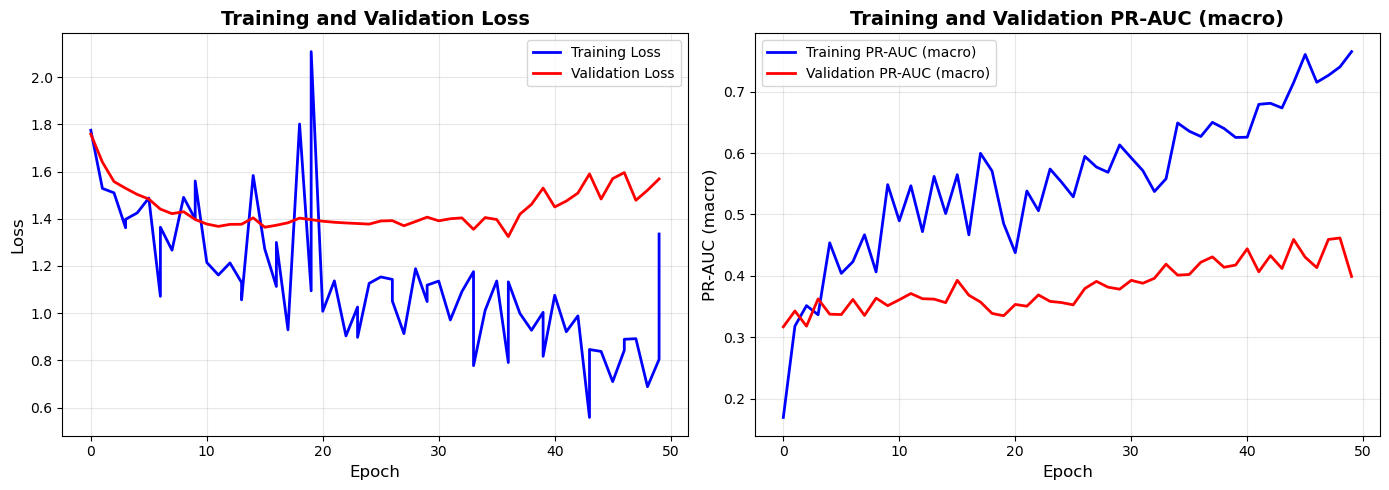

In [136]:
import matplotlib.pyplot as plt

# Plot training history from PyTorch Lightning logs
metrics_df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss curves
train_loss = metrics_df.dropna(subset=['train_loss'])
val_loss = metrics_df.dropna(subset=['val_loss'])

ax1.plot(train_loss['epoch'], train_loss['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(val_loss['epoch'], val_loss['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot metric curves
metric_name = METRIC_CONFIG[PRIMARY_METRIC]['monitor']
train_metric_name = metric_name.replace('val_', 'train_')
train_metric = metrics_df.dropna(subset=[train_metric_name])
val_metric = metrics_df.dropna(subset=[metric_name])

ax2.plot(train_metric['epoch'], train_metric[train_metric_name], 'b-', 
         label=f'Training {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', linewidth=2)
ax2.plot(val_metric['epoch'], val_metric[metric_name], 'r-', 
         label=f'Validation {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel(METRIC_CONFIG[PRIMARY_METRIC]['name'], fontsize=12)
ax2.set_title(f'Training and Validation {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [137]:
# Load best model and evaluate
logger.info("\n" + "="*80)
logger.info("MODEL EVALUATION - Loading Best Model")
logger.info("="*80)

best_model = FlagPatternClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    input_dim=X.shape[2],
    num_classes=num_classes,
    class_weights=class_weights,
    weights_only=False  # Allow loading numpy arrays from checkpoint
)
best_model.eval()
best_model.freeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

logger.info(f"Best model loaded from: {checkpoint_callback.best_model_path}")
logger.info(f"Device: {device}")

def get_predictions(loader, model):
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    
    return np.concatenate(all_preds), np.concatenate(all_targets), np.concatenate(all_probs)

train_preds, train_targets, train_probs = get_predictions(train_loader, best_model)
val_preds, val_targets, val_probs = get_predictions(val_loader, best_model)

# Calculate metrics
train_acc = accuracy_score(train_targets, train_preds)
train_f1 = f1_score(train_targets, train_preds, average='macro')
train_auc_ovo = roc_auc_score(train_targets, train_probs, multi_class='ovo', average='macro')
train_auc_ovr = roc_auc_score(train_targets, train_probs, multi_class='ovr', average='macro')

val_acc = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='macro')
val_auc_ovo = roc_auc_score(val_targets, val_probs, multi_class='ovo', average='macro')
val_auc_ovr = roc_auc_score(val_targets, val_probs, multi_class='ovr', average='macro')

train_targets_bin = label_binarize(train_targets, classes=range(num_classes))
val_targets_bin = label_binarize(val_targets, classes=range(num_classes))

train_pr_auc_per_class = [average_precision_score(train_targets_bin[:, i], train_probs[:, i]) for i in range(num_classes)]
val_pr_auc_per_class = [average_precision_score(val_targets_bin[:, i], val_probs[:, i]) for i in range(num_classes)]

train_pr_auc = np.mean(train_pr_auc_per_class)
val_pr_auc = np.mean(val_pr_auc_per_class)

logger.info("\n" + "="*80)
logger.info("VALIDATION RESULTS (Best Model)")
logger.info("="*80)
logger.info(f"Training Set:")
logger.info(f"  Accuracy:         {train_acc:.4f}")
logger.info(f"  F1 Score (macro): {train_f1:.4f}")
logger.info(f"  PR-AUC (macro):   {train_pr_auc:.4f}")
logger.info(f"  AUC-ROC (OvO):    {train_auc_ovo:.4f}")
logger.info(f"  AUC-ROC (OvR):    {train_auc_ovr:.4f}")
logger.info(f"\nValidation Set:")
logger.info(f"  Accuracy:         {val_acc:.4f}")
logger.info(f"  F1 Score (macro): {val_f1:.4f}")
logger.info(f"  PR-AUC (macro):   {val_pr_auc:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'pr_auc' else ''}")
logger.info(f"  AUC-ROC (OvO):    {val_auc_ovo:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovo' else ''}")
logger.info(f"  AUC-ROC (OvR):    {val_auc_ovr:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovr' else ''}")

2025-12-13 08:41:19,248 - INFO - 
2025-12-13 08:41:19,249 - INFO - MODEL EVALUATION - Loading Best Model
2025-12-13 08:41:19,250 - INFO - ================================================================================
2025-12-13 08:41:19,320 - INFO - Best model loaded from: /work/data/export/checkpoints_v2/best_model_pr_epoch=48_val_pr_auc=0.4617.ckpt
2025-12-13 08:41:19,321 - INFO - Device: cuda
2025-12-13 08:41:19,373 - INFO - 
2025-12-13 08:41:19,374 - INFO - VALIDATION RESULTS (Best Model)
2025-12-13 08:41:19,375 - INFO - ================================================================================
2025-12-13 08:41:19,375 - INFO - Training Set:
2025-12-13 08:41:19,376 - INFO -   Accuracy:         0.8425
2025-12-13 08:41:19,376 - INFO -   F1 Score (macro): 0.8477
2025-12-13 08:41:19,377 - INFO -   PR-AUC (macro):   0.9442
2025-12-13 08:41:19,378 - INFO -   AUC-ROC (OvO):    0.9860
2025-12-13 08:41:19,378 - INFO -   AUC-ROC (OvR):    0.9854
2025-12-13 08:41:19,379 - INFO - 
Valid

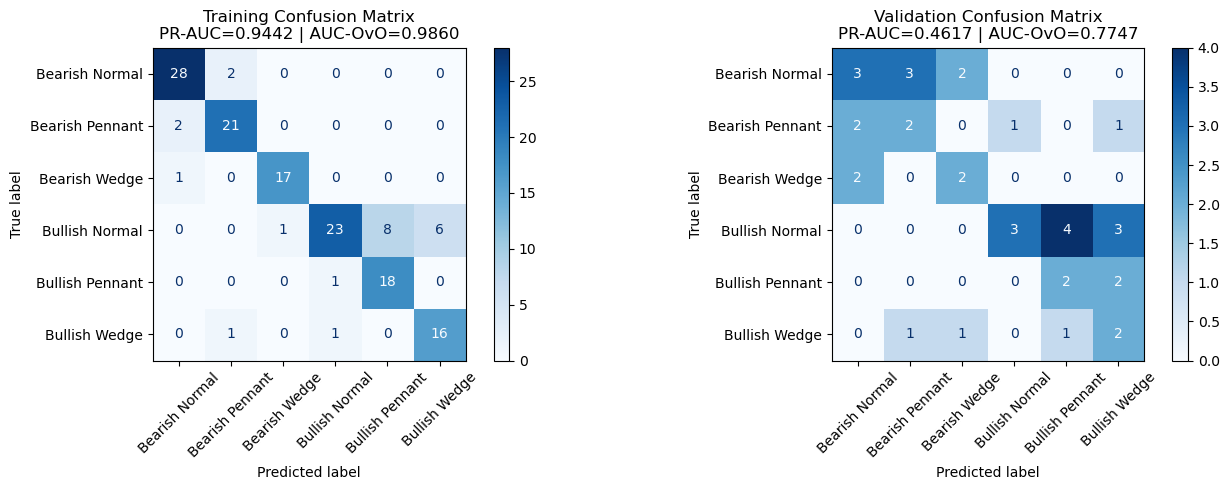


Classification report (validation):
                 precision    recall  f1-score   support

 Bearish Normal       0.43      0.38      0.40         8
Bearish Pennant       0.33      0.33      0.33         6
  Bearish Wedge       0.40      0.50      0.44         4
 Bullish Normal       0.75      0.30      0.43        10
Bullish Pennant       0.29      0.50      0.36         4
  Bullish Wedge       0.25      0.40      0.31         5

       accuracy                           0.38        37
      macro avg       0.41      0.40      0.38        37
   weighted avg       0.46      0.38      0.39        37



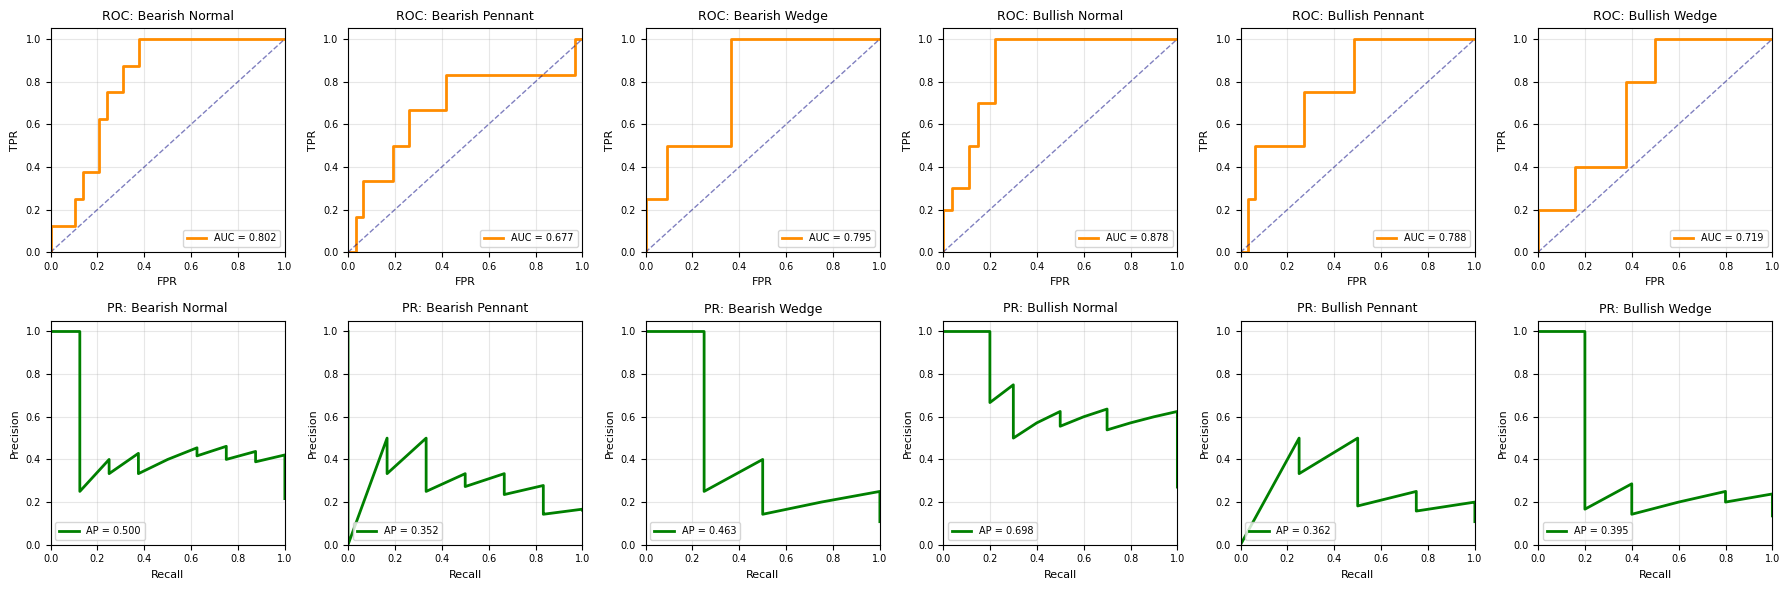

In [138]:
# Visualization - Confusion matrices and curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_train = confusion_matrix(train_targets, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_values)
disp_train.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title(f"Training Confusion Matrix\nPR-AUC={train_pr_auc:.4f} | AUC-OvO={train_auc_ovo:.4f}")

cm_val = confusion_matrix(val_targets, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_values)
disp_val.plot(ax=axes[1], cmap='Blues', xticks_rotation=45)
axes[1].set_title(f"Validation Confusion Matrix\nPR-AUC={val_pr_auc:.4f} | AUC-OvO={val_auc_ovo:.4f}")

plt.tight_layout()
plt.show()

print("\nClassification report (validation):")
print(classification_report(val_targets, val_preds, target_names=[str(lbl) for lbl in label_values]))

# Plot ROC and PR curves
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(num_classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(val_targets_bin[:, i], val_probs[:, i])
    roc_auc_class = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_class:.3f}')
    axes[0, i].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.5)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('FPR', fontsize=8)
    axes[0, i].set_ylabel('TPR', fontsize=8)
    axes[0, i].set_title(f'ROC: {label_values[i]}', fontsize=9)
    axes[0, i].legend(loc="lower right", fontsize=7)
    axes[0, i].grid(alpha=0.3)
    axes[0, i].tick_params(labelsize=7)
    
    # PR curve
    precision, recall, _ = precision_recall_curve(val_targets_bin[:, i], val_probs[:, i])
    pr_auc_class = val_pr_auc_per_class[i]
    
    axes[1, i].plot(recall, precision, color='green', lw=2, label=f'AP = {pr_auc_class:.3f}')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall', fontsize=8)
    axes[1, i].set_ylabel('Precision', fontsize=8)
    axes[1, i].set_title(f'PR: {label_values[i]}', fontsize=9)
    axes[1, i].legend(loc="lower left", fontsize=7)
    axes[1, i].grid(alpha=0.3)
    axes[1, i].tick_params(labelsize=7)

plt.tight_layout()
plt.show()

In [139]:
# Reload the baseline_model module to pick up any changes
import importlib
import sys

# Remove cached module if it exists
if 'baseline_model' in sys.modules:
    del sys.modules['baseline_model']

# Re-import
import baseline_model
print("Baseline model reloaded with current slope_threshold:", baseline_model.BaselineModel().slope_threshold)

Baseline model reloaded with current slope_threshold: 0.0002


Using segments CSV for baseline: /work/data/export/segments_values.csv
Baseline results shape: (204, 4)
Using slope_threshold: 0.0002
Number of evaluated segments: 204
Baseline accuracy: 0.3676
Baseline F1 score (macro): 0.3263
Baseline classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Classification report (baseline):
                 precision    recall  f1-score   support

 Bearish Normal       0.42      0.36      0.38        42
Bearish Pennant       0.29      0.12      0.17        32
  Bearish Wedge       0.30      0.56      0.39        25
 Bullish Normal       0.49      0.57      0.53        53
Bullish Pennant       0.44      0.15      0.23        26
  Bullish Wedge       0.21      0.31      0.25        26

       accuracy                           0.37       204
      macro avg       0.36      0.34      0.33       204
   weighted avg       0.38      0.37      0.35       204



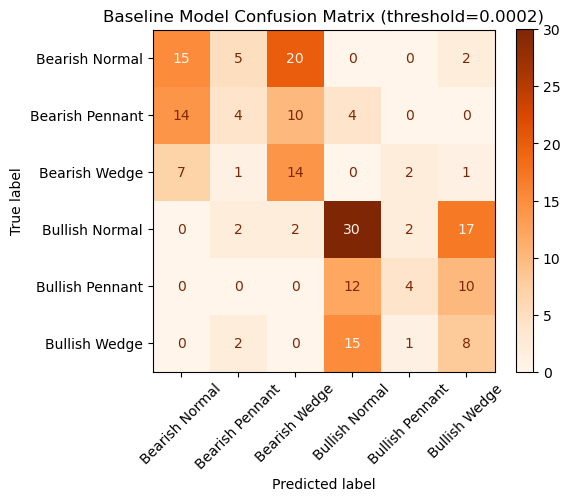

In [140]:
# Evaluate baseline model on the combined segments CSV and plot confusion matrix
import os
from baseline_model import predict_from_segments_csv, evaluate_on_segments_csv

# Path to the combined segment CSV produced by 01-data-exploration.ipynb
segments_csv_path = os.path.abspath("../data/export/segments_values.csv")
print("Using segments CSV for baseline:", segments_csv_path)

# Custom slope threshold for baseline model
BASELINE_SLOPE_THRESHOLD = 0.0002

# Run baseline model on all segments; this returns a DataFrame
baseline_results = predict_from_segments_csv(segments_csv_path, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print("Baseline results shape:", baseline_results.shape)
print(f"Using slope_threshold: {BASELINE_SLOPE_THRESHOLD}")

# Keep only rows with ground-truth labels
mask = baseline_results["gold_label"].notna()
baseline_labels = baseline_results.loc[mask, "gold_label"].values
baseline_preds = baseline_results.loc[mask, "predicted_label"].values

print("Number of evaluated segments:", baseline_labels.shape[0])

# Print accuracy, F1 score, and classification report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
baseline_acc = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='macro')
print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 score (macro): {baseline_f1:.4f}")

# Use label set from the baseline outputs
import numpy as np
baseline_label_values = np.sort(pd.unique(baseline_labels))
print("Baseline classes:", baseline_label_values)

print("\nClassification report (baseline):")
print(classification_report(baseline_labels, baseline_preds,
                            labels=baseline_label_values,
                            target_names=[str(lbl) for lbl in baseline_label_values]))

# Plot confusion matrix for baseline model
import matplotlib.pyplot as plt
cm_baseline = confusion_matrix(baseline_labels, baseline_preds, labels=baseline_label_values)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=baseline_label_values)
fig, ax = plt.subplots(figsize=(6, 5))
disp_baseline.plot(ax=ax, cmap="Oranges", xticks_rotation=45)
ax.set_title(f"Baseline Model Confusion Matrix (threshold={BASELINE_SLOPE_THRESHOLD})")
plt.tight_layout()
plt.show()

Confusion matrix classes (ordered): ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']


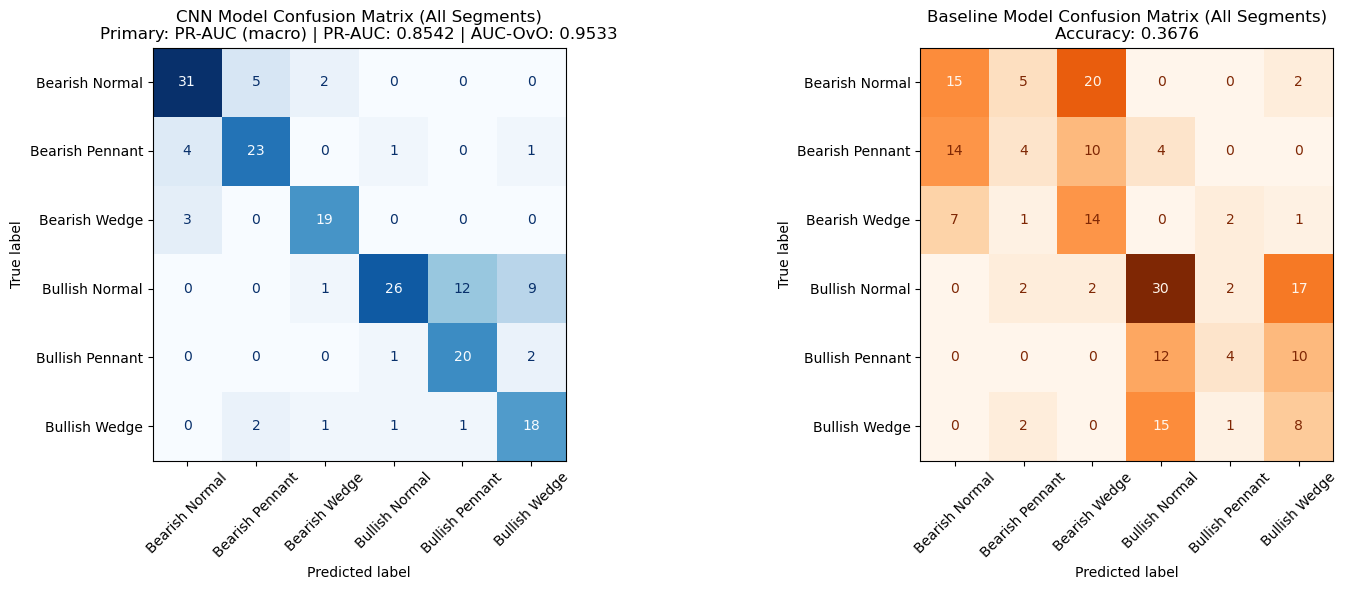


MODEL COMPARISON SUMMARY
CNN Model (selected by PR-AUC (macro)):
  Accuracy:         0.7486
  F1 Score (macro): 0.7515
  PR-AUC (macro):   0.8542  ← precision-recall curve
  AUC-ROC (OvO):    0.9533  ← pairwise discrimination (15 comparisons)
  AUC-ROC (OvR):    0.9519  ← each-vs-rest (6 comparisons)

Baseline Model (heuristic):
  Accuracy:         0.3676
  F1 Score (macro): 0.3263

PR-AUC is particularly useful for imbalanced datasets
It focuses on positive class performance and precision-recall trade-offs


In [141]:
# Compare confusion matrices of CNN model vs baseline on all segments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

# 1) CNN model predictions on all segments used for training
full_ds = SegmentDataset(X, y_idx)
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

cnn_preds_all, cnn_targets_all, cnn_probs_all = get_predictions(full_loader, best_model)

# Map integer indices back to label strings
cnn_true_labels = np.vectorize(idx_to_label.get)(cnn_targets_all)
cnn_pred_labels = np.vectorize(idx_to_label.get)(cnn_preds_all)

# Calculate all CNN metrics
cnn_acc = accuracy_score(cnn_true_labels, cnn_pred_labels)
cnn_f1 = f1_score(cnn_true_labels, cnn_pred_labels, average='macro')
cnn_auc_ovo = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovo', average='macro')
cnn_auc_ovr = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovr', average='macro')

# Calculate PR-AUC for CNN
cnn_targets_bin = label_binarize(cnn_targets_all, classes=range(num_classes))
cnn_pr_auc_per_class = [average_precision_score(cnn_targets_bin[:, i], cnn_probs_all[:, i]) for i in range(num_classes)]
cnn_pr_auc = np.mean(cnn_pr_auc_per_class)

# 2) Baseline predictions (already computed from segments_values.csv)
#    Using baseline_labels and baseline_preds from the previous cell

# Use the global label set from the CNN pipeline for consistent ordering
all_labels = label_values
print("Confusion matrix classes (ordered):", all_labels)

cm_cnn_all = confusion_matrix(cnn_true_labels, cnn_pred_labels, labels=all_labels)
cm_baseline_all = confusion_matrix(baseline_labels, baseline_preds, labels=all_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN confusion matrix
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_all, display_labels=all_labels)
cnn_disp.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title(f"CNN Model Confusion Matrix (All Segments)\n"
                  f"Primary: {METRIC_CONFIG[PRIMARY_METRIC]['name']} | "
                  f"PR-AUC: {cnn_pr_auc:.4f} | AUC-OvO: {cnn_auc_ovo:.4f}")

# Baseline confusion matrix
base_disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_all, display_labels=all_labels)
base_disp.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title(f"Baseline Model Confusion Matrix (All Segments)\nAccuracy: {baseline_acc:.4f}")

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"CNN Model (selected by {METRIC_CONFIG[PRIMARY_METRIC]['name']}):")
print(f"  Accuracy:         {cnn_acc:.4f}")
print(f"  F1 Score (macro): {cnn_f1:.4f}")
print(f"  PR-AUC (macro):   {cnn_pr_auc:.4f}  ← precision-recall curve")
print(f"  AUC-ROC (OvO):    {cnn_auc_ovo:.4f}  ← pairwise discrimination (15 comparisons)")
print(f"  AUC-ROC (OvR):    {cnn_auc_ovr:.4f}  ← each-vs-rest (6 comparisons)")
print(f"\nBaseline Model (heuristic):")
print(f"  Accuracy:         {baseline_acc:.4f}")
print(f"  F1 Score (macro): {baseline_f1:.4f}")
print("="*70)
print(f"\nPR-AUC is particularly useful for imbalanced datasets")
print(f"It focuses on positive class performance and precision-recall trade-offs")

2025-12-13 08:41:20,836 - INFO - 
2025-12-13 08:41:20,838 - INFO - TEST SET EVALUATION - CNN Model
2025-12-13 08:41:20,838 - INFO - ================================================================================
2025-12-13 08:41:20,839 - INFO - Loading test data from:
2025-12-13 08:41:20,840 - INFO -   Preprocessed: /work/data/export/segments_preproc_24_test.csv
2025-12-13 08:41:20,841 - INFO -   Raw (for baseline): /work/data/export/segments_test_raw.csv
2025-12-13 08:41:20,853 - INFO - Test set loaded: 21 segments
2025-12-13 08:41:20,853 - INFO - Test label distribution:
2025-12-13 08:41:20,854 - INFO -   Bullish Normal: 5 samples (23.8%)
2025-12-13 08:41:20,855 - INFO -   Bearish Normal: 4 samples (19.0%)
2025-12-13 08:41:20,855 - INFO -   Bearish Pennant: 3 samples (14.3%)
2025-12-13 08:41:20,856 - INFO -   Bullish Pennant: 3 samples (14.3%)
2025-12-13 08:41:20,857 - INFO -   Bearish Wedge: 3 samples (14.3%)
2025-12-13 08:41:20,858 - INFO -   Bullish Wedge: 3 samples (14.3%)
2025-

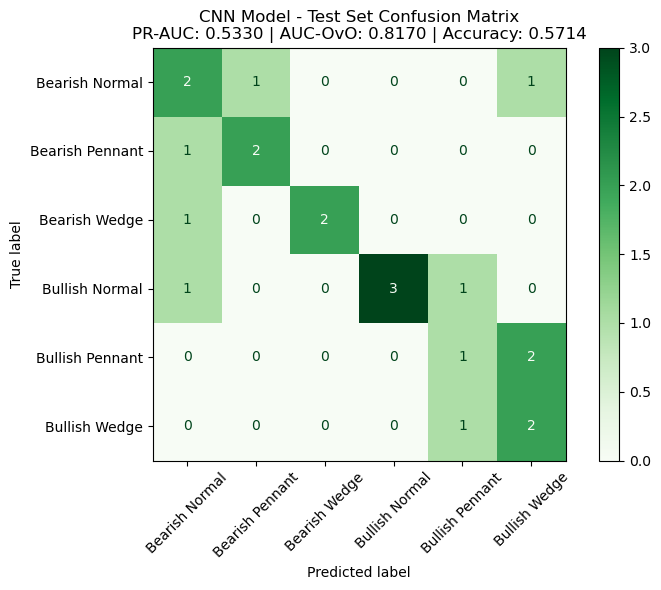

In [142]:
# Evaluate on held-out test set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, roc_auc_score, 
    average_precision_score
)
from sklearn.preprocessing import label_binarize

logger.info("\n" + "="*80)
logger.info("TEST SET EVALUATION - CNN Model")
logger.info("="*80)

# Load test data
TEST_PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24_test.csv")
TEST_RAW_CSV = os.path.join(EXPORT_DIR, "segments_test_raw.csv")

logger.info(f"Loading test data from:")
logger.info(f"  Preprocessed: {TEST_PREPROC_CSV}")
logger.info(f"  Raw (for baseline): {TEST_RAW_CSV}")

df_test = pd.read_csv(TEST_PREPROC_CSV)
df_test = df_test.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

# Build test sequences (same as training pipeline)
test_segments = []
test_labels = []

for seg_id, g in df_test.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    
    # Pad or truncate to 24 steps
    if feat.shape[0] < 24:
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        feat = feat[:24, :]
    
    assert feat.shape[0] == 24, feat.shape
    test_segments.append(feat)
    test_labels.append(g["label"].iloc[0])

X_test = np.stack(test_segments, axis=0)
y_test_str = np.array(test_labels)
y_test = np.vectorize(label_to_idx.get)(y_test_str)

logger.info(f"Test set loaded: {X_test.shape[0]} segments")
logger.info("Test label distribution:")
test_label_dist = pd.Series(y_test_str).value_counts()
for label, count in test_label_dist.items():
    logger.info(f"  {label}: {count} samples ({count/len(y_test_str)*100:.1f}%)")

# Create test dataset and loader
test_ds = SegmentDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Get predictions on test set
test_preds, test_targets, test_probs = get_predictions(test_loader, best_model)

# Calculate all metrics for test set
test_acc = accuracy_score(test_targets, test_preds)
test_f1 = f1_score(test_targets, test_preds, average='macro')
test_auc_ovo = roc_auc_score(test_targets, test_probs, multi_class='ovo', average='macro')
test_auc_ovr = roc_auc_score(test_targets, test_probs, multi_class='ovr', average='macro')

# Calculate PR-AUC
test_targets_bin = label_binarize(test_targets, classes=range(num_classes))
test_pr_auc_per_class = [average_precision_score(test_targets_bin[:, i], test_probs[:, i]) for i in range(num_classes)]
test_pr_auc = np.mean(test_pr_auc_per_class)

# Map predictions back to labels
test_true_labels = np.vectorize(idx_to_label.get)(test_targets)
test_pred_labels = np.vectorize(idx_to_label.get)(test_preds)

logger.info("\n" + "="*80)
logger.info("FINAL EVALUATION - Test Set Results (CNN Model)")
logger.info("="*80)
logger.info(f"Accuracy:         {test_acc:.4f}")
logger.info(f"F1 Score (macro): {test_f1:.4f}")
logger.info(f"PR-AUC (macro):   {test_pr_auc:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'pr_auc' else ''}")
logger.info(f"AUC-ROC (OvO):    {test_auc_ovo:.4f}")
logger.info(f"AUC-ROC (OvR):    {test_auc_ovr:.4f}")

# Log confusion matrix
cm_test = confusion_matrix(test_true_labels, test_pred_labels, labels=label_values)
logger.info("\nConfusion Matrix (Test Set):")
logger.info(f"Classes: {list(label_values)}")
for i, row in enumerate(cm_test):
    logger.info(f"  {label_values[i]}: {list(row)}")

# Log classification report
logger.info("\nDetailed Classification Report (Test Set):")
report = classification_report(test_true_labels, test_pred_labels, target_names=[str(lbl) for lbl in label_values])
for line in report.split('\n'):
    if line.strip():
        logger.info(f"  {line}")

# Plot test confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_values)
disp_test.plot(ax=ax, cmap="Greens", xticks_rotation=45, colorbar=True)
ax.set_title(f"CNN Model - Test Set Confusion Matrix\n"
             f"PR-AUC: {test_pr_auc:.4f} | AUC-OvO: {test_auc_ovo:.4f} | Accuracy: {test_acc:.4f}")
plt.tight_layout()
plt.show()


TEST SET EVALUATION - BASELINE MODEL


Baseline test results shape: (21, 4)
Number of evaluated test segments: 21
Accuracy:         0.2857
F1 Score (macro): 0.2023


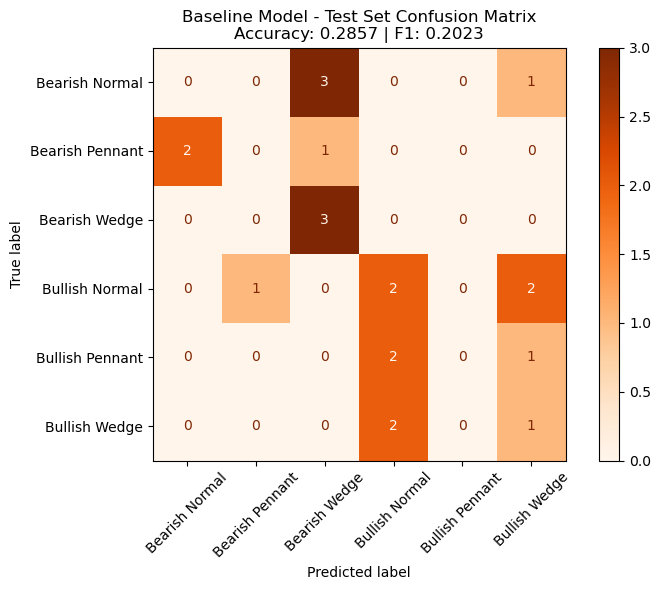


Classification Report (Baseline - Test Set):
                 precision    recall  f1-score   support

 Bearish Normal       0.00      0.00      0.00         4
Bearish Pennant       0.00      0.00      0.00         3
  Bearish Wedge       0.43      1.00      0.60         3
 Bullish Normal       0.33      0.40      0.36         5
Bullish Pennant       0.00      0.00      0.00         3
  Bullish Wedge       0.20      0.33      0.25         3

       accuracy                           0.29        21
      macro avg       0.16      0.29      0.20        21
   weighted avg       0.17      0.29      0.21        21



/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

In [143]:
# Evaluate baseline model on test set
from baseline_model import predict_from_segments_csv

print("\n" + "="*70)
print("TEST SET EVALUATION - BASELINE MODEL")
print("="*70)

# Run baseline on test raw data
baseline_test_results = predict_from_segments_csv(TEST_RAW_CSV, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print(f"Baseline test results shape: {baseline_test_results.shape}")

# Keep only rows with ground-truth labels
mask_test = baseline_test_results["gold_label"].notna()
baseline_test_labels = baseline_test_results.loc[mask_test, "gold_label"].values
baseline_test_preds = baseline_test_results.loc[mask_test, "predicted_label"].values

print(f"Number of evaluated test segments: {baseline_test_labels.shape[0]}")

# Calculate metrics
baseline_test_acc = accuracy_score(baseline_test_labels, baseline_test_preds)
baseline_test_f1 = f1_score(baseline_test_labels, baseline_test_preds, average='macro')

print(f"Accuracy:         {baseline_test_acc:.4f}")
print(f"F1 Score (macro): {baseline_test_f1:.4f}")
print("="*70)

# Plot baseline test confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_baseline_test = confusion_matrix(baseline_test_labels, baseline_test_preds, labels=label_values)
disp_baseline_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_test, display_labels=label_values)
disp_baseline_test.plot(ax=ax, cmap="Oranges", xticks_rotation=45, colorbar=True)
ax.set_title(f"Baseline Model - Test Set Confusion Matrix\n"
             f"Accuracy: {baseline_test_acc:.4f} | F1: {baseline_test_f1:.4f}")
plt.tight_layout()
plt.show()

print("\nClassification Report (Baseline - Test Set):")
print(classification_report(baseline_test_labels, baseline_test_preds, 
                            labels=label_values,
                            target_names=[str(lbl) for lbl in label_values]))

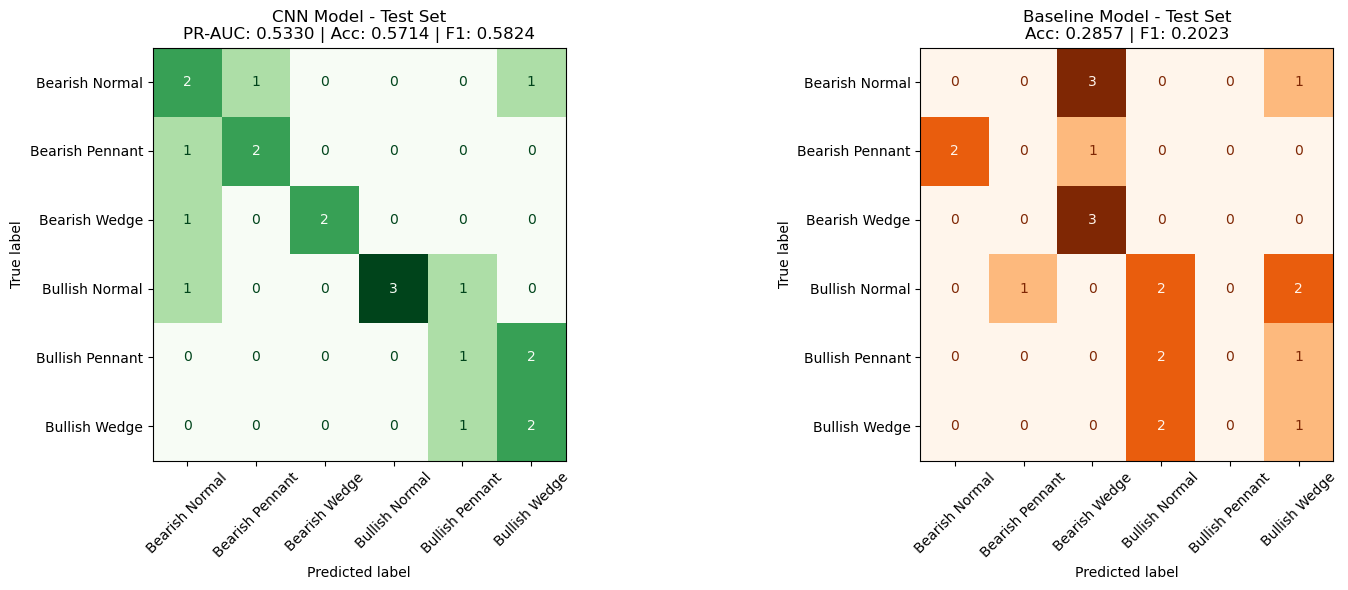

2025-12-13 08:41:21,282 - INFO - 
2025-12-13 08:41:21,283 - INFO - FINAL MODEL COMPARISON - Test Set Performance
2025-12-13 08:41:21,283 - INFO - ================================================================================
2025-12-13 08:41:21,284 - INFO - 
CNN Model (Deep Learning):
2025-12-13 08:41:21,285 - INFO -   Accuracy:         0.5714
2025-12-13 08:41:21,286 - INFO -   F1 Score (macro): 0.5824
2025-12-13 08:41:21,286 - INFO -   PR-AUC (macro):   0.5330
2025-12-13 08:41:21,287 - INFO -   AUC-ROC (OvO):    0.8170
2025-12-13 08:41:21,287 - INFO -   AUC-ROC (OvR):    0.8143
2025-12-13 08:41:21,288 - INFO - 
Baseline Model (Heuristic):
2025-12-13 08:41:21,289 - INFO -   Accuracy:         0.2857
2025-12-13 08:41:21,289 - INFO -   F1 Score (macro): 0.2023
2025-12-13 08:41:21,290 - INFO - 
Improvement (CNN vs Baseline):
2025-12-13 08:41:21,291 - INFO -   Accuracy:  +0.2857 (+100.0%)
2025-12-13 08:41:21,292 - INFO -   F1 Score:  +0.3801 (+187.9%)
2025-12-13 08:41:21,299 - INFO - 
202

In [144]:
# Side-by-side comparison: CNN vs Baseline on Test Set
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN test confusion matrix
cnn_disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_values)
cnn_disp_test.plot(ax=axes[0], cmap="Greens", xticks_rotation=45, colorbar=False)
axes[0].set_title(f"CNN Model - Test Set\n"
                  f"PR-AUC: {test_pr_auc:.4f} | Acc: {test_acc:.4f} | F1: {test_f1:.4f}")

# Baseline test confusion matrix
base_disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_test, display_labels=label_values)
base_disp_test.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title(f"Baseline Model - Test Set\n"
                  f"Acc: {baseline_test_acc:.4f} | F1: {baseline_test_f1:.4f}")

plt.tight_layout()
plt.show()

# Print comprehensive comparison
logger.info("\n" + "="*80)
logger.info("FINAL MODEL COMPARISON - Test Set Performance")
logger.info("="*80)
logger.info(f"\nCNN Model (Deep Learning):")
logger.info(f"  Accuracy:         {test_acc:.4f}")
logger.info(f"  F1 Score (macro): {test_f1:.4f}")
logger.info(f"  PR-AUC (macro):   {test_pr_auc:.4f}")
logger.info(f"  AUC-ROC (OvO):    {test_auc_ovo:.4f}")
logger.info(f"  AUC-ROC (OvR):    {test_auc_ovr:.4f}")

logger.info(f"\nBaseline Model (Heuristic):")
logger.info(f"  Accuracy:         {baseline_test_acc:.4f}")
logger.info(f"  F1 Score (macro): {baseline_test_f1:.4f}")

acc_improvement = test_acc - baseline_test_acc
f1_improvement = test_f1 - baseline_test_f1
acc_pct = (test_acc / baseline_test_acc - 1) * 100 if baseline_test_acc > 0 else 0
f1_pct = (test_f1 / baseline_test_f1 - 1) * 100 if baseline_test_f1 > 0 else 0

logger.info(f"\nImprovement (CNN vs Baseline):")
logger.info(f"  Accuracy:  {acc_improvement:+.4f} ({acc_pct:+.1f}%)")
logger.info(f"  F1 Score:  {f1_improvement:+.4f} ({f1_pct:+.1f}%)")

logger.info("\n" + "="*80)
logger.info("EXPERIMENT COMPLETED SUCCESSFULLY")
logger.info(f"Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.info("="*80)